# Validation

**Learning Objectives**
* Use multiple features, instead of a single feature, to further improve the effectiveness of a model.
* Debug issues in model input data.
* Use a test data set to check if a model is overfitting the validation data.

As with prior exercises, we are going to work with the California housing data set to try to predict the median_house_value at the city block level from the 1990 census data.

The initial setup is as the previous exercises.

In [11]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

# california_housing_dataframe = california_housing_dataframe.reindex(
#     np.random.permutation(california_housing_dataframe.index))

# The Same Code But With Randomization Uncommented

In [47]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
                                 np.random.permutation(california_housing_dataframe.index))

In [48]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
    
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    #Create a synthetic feature.
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"]/
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
    output_targets = pd.DataFrame()
    #Scale the target to be in thousands of dollars.
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets      

We will now create our **training set**, we will choose the first 12000 examples out of the 17000 total.

In [49]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,2668.3,544.3,1443.2,505.4,3.9,2.0
std,2.1,2.0,12.6,2242.2,432.8,1188.3,393.4,1.9,1.0
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1462.0,297.0,790.8,281.0,2.6,1.5
50%,34.2,-118.5,28.0,2130.5,435.0,1170.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3174.2,652.0,1727.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,41.3


In [50]:
training_examples.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
16098,38.5,-122.5,32.0,1735.0,331.0,785.0,309.0,3.7,2.2
1520,33.3,-117.2,10.0,5294.0,817.0,2312.0,810.0,5.5,2.3
16346,39.0,-122.5,16.0,975.0,219.0,337.0,155.0,1.7,2.9
15069,37.8,-122.2,39.0,461.0,129.0,381.0,123.0,1.6,1.2
13867,37.3,-122.0,25.0,3845.0,492.0,1461.0,475.0,10.4,2.6


In [51]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.3
std,115.5
min,15.0
25%,119.8
50%,181.3
75%,265.5
max,500.0


In [52]:
training_targets.head(40)

,median_house_value
16098,275.8
1520,325.7
16346,77.8
15069,112.5
13867,500.0
...,...
8400,500.0
7185,237.5
16815,149.3
3602,181.3


Now we define our **validation set** as the last 5000 examples, out of the total of 17,000.

In [53]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.7,2584.6,527.7,1396.9,491.3,3.9,2.0
std,2.1,2.0,12.6,2021.8,392.9,1043.9,362.1,1.9,1.5
min,32.5,-124.3,1.0,12.0,3.0,3.0,4.0,0.5,0.1
25%,33.9,-121.8,18.0,1461.8,296.0,788.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2120.0,431.0,1160.5,406.0,3.5,1.9
75%,37.7,-118.0,37.0,3087.2,642.0,1705.5,600.0,4.7,2.3
max,41.9,-114.6,52.0,27700.0,4952.0,15037.0,4616.0,15.0,55.2


In [54]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,207.3
std,117.1
min,22.5
25%,119.2
50%,178.4
75%,264.4
max,500.0


# Task 1: Examine the Data
Let's take a look at the data above. We have 9 input features that we can use.

Notice there are some oddities in the data such as:
* median_income is on some scale from about 3 to 15. It is not clear or documented what this scale may be. We will assume that a higher number indicates a higher income.
* The maximum median_house_value is about 500,001. This seems to be an artificial cap.
* Our rooms_per_person feature is scaled well, with about 75% of the data having a value of 2. However there are some very large values in the data set with 18 or 55 rooms which hint that the data may be slightly corrupted.
For now we will use the features as given, but this yields intuition as to how to check data presented from an unknown source.

# Task 2: Plot Latitude/Longitude vs. Median House Value

Lets take a look at two features in particular: latitude and longitude. These are geographical coordinates of the city block in question.

This might make a nice visualization! Let's plot latitude and longitude and use color to show the median_house_value.

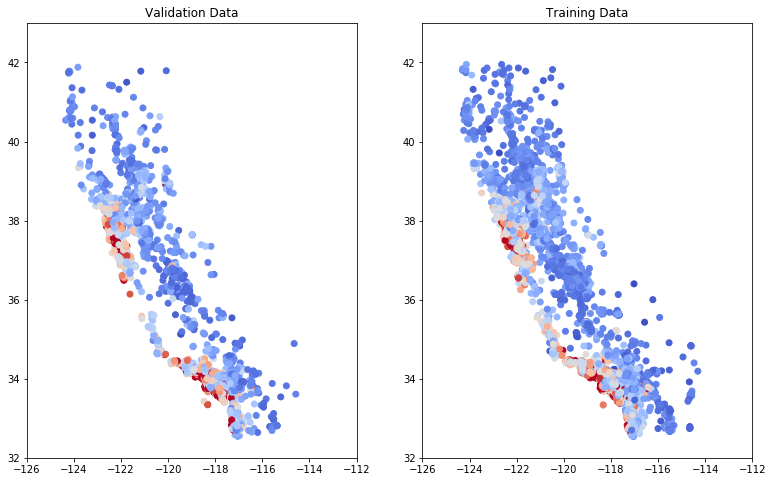

In [55]:
plt.figure(figsize=(13,8))

ax = plt.subplot(1,2,1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
           cmap="coolwarm",
           c = validation_targets["median_house_value"]/validation_targets["median_house_value"].max())
ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
           cmap="coolwarm",
           c=training_targets["median_house_value"]/training_targets["median_house_value"].max())

_=plt.plot()


The maps we have created represent the state of California, with red representing expensive areas like San Francisco and Los Angeles. Although our training set has a nice distribution of data, our validation set clearly doesn't. It is important to notice that for any given feature or column, the distribution of values between the train and validation sets should be reoughly equal.
This is clearly not the case and so there is a fault as to how our train and validation sets were split.

# Task 3: Return to the Data Importing and Pre-Processing Code and Spot Bugs

**Debugging in Machine Learning is often data debugging, rather than code debugging**

***If the data is wrong, even the most advanced Machine Learning code cannot solve things.***

Notice how the initial data was not randomized. The code that randomizes the data (np.random.permutation) is commented out. We need to randomize data properly prior to creating training and validation splits. As we can see, we ran into issues here since the data was presented to us in a sorted order.

# Task 4: Train and Evaluate a Model


Like the previous exercises we will train a linear regressor using all the features in the data set available. We will compare the results from this model to the one obtained in our previous exercise.
We import the same input function from the previous exercise for loading data into a TensorFlow model.

In [57]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

Since we are working with multiple input features, we will modularize our code for configuring feature columns into a separate function. 

In [59]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    
    Args:
        input_features: The names of the numerical input feautres to use.
    Returns:
        A set of feature columns
    
    """
    return set([tf.feature_column.numeric_column(my_feature)
                for my_feature in input_features])

In [62]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples,
      training_targets["median_house_value"],
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples,
  training_targets["median_house_value"],
  num_epochs=1,
  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"],
      num_epochs=1,
      shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Now lets run the linear regressor and see how well our predictions fare. Compare the losses on the training data with the validation data. Recall that with a single raw feature, the best root mean squared error we achieved was about 180. Let's see how much better we can perform with multiple features feeding into our model.

Training model...
RMSE (on training data):
  period 00 : 217.03
  period 01 : 199.26
  period 02 : 184.92
  period 03 : 176.17
  period 04 : 170.43
  period 05 : 167.87
  period 06 : 167.26
  period 07 : 167.99
  period 08 : 169.59
  period 09 : 171.47
Model training finished.


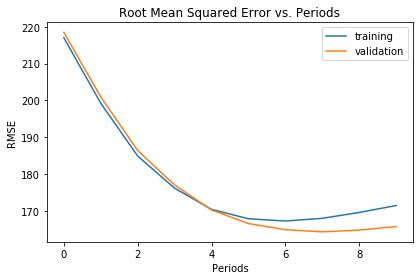

In [64]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

# Task 5: Evaluate on Test Data

We have performed several iterations on our validation data. We should double check that we haven't overfit our data to the peculiarities of that one particular sample.

In [65]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 162.98
